## Finding Your Way In The City (Graph Edition)
In this notebook your attention will shift from grids to graphs. At least for search ... the world representation is still a grid. You likely noticed in the previous notebook the generated paths flew as close to the obstacle / safety space as possible.

Using Voronoi graphs and the medial axis transform we can find paths which maximize safety from obstacles. In addition, graph representation allows further optimizations and more succinct queries.

In [37]:
from planning_utils import calc_offset_gridsize, create_voronoi, closest_point
from planning_utils import a_star_graph, heuristic, prune_path
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline 
import networkx as nx
# Should be 2.1
nx.__version__

'2.1'

In [38]:
plt.rcParams['figure.figsize'] = 8, 8

In [6]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Starting and goal positions in *(north, east)*.

In [29]:
# Local Start:  (316, 445)
# Local Goal:  (907, 723)
# start_ne = (25,  100)
# goal_ne = (750., 370.)
start_ne = (316, 445)
goal_ne = (638, 157)

In [8]:
# Static drone altitude (metres)
drone_altitude = 5
safety_distance = 5

In [16]:
def create_grid(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min + 1)))
    east_size = int(np.ceil((east_max - east_min + 1)))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))

    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1)),
            ]
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = alt + d_alt

    return grid, int(north_min), int(east_min)

In [17]:
grid, _ , _ = create_grid(data, drone_altitude, safety_distance)

Plot the edges on top of the grid along with start and goal locations.

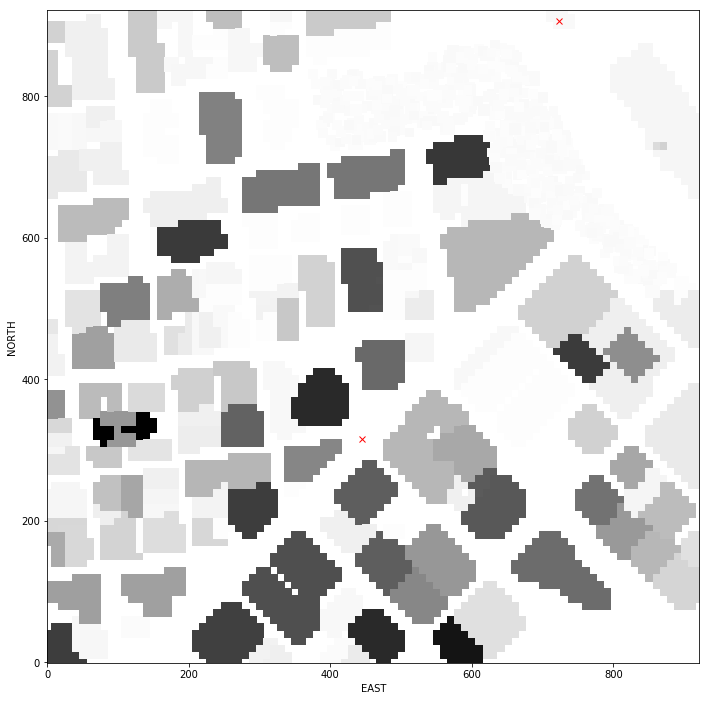

In [19]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()
plt.show()

We now have a graph, well at least visually. The next step is to use the [`networkx`](https://networkx.github.io) to create the graph. **NetworkX** is a popular library handling anything and everything related to graph data structures and algorithms.

**NOTE:** In the initial import above it was imported with the `nx` alias.

You're encouraged to read the documentation but here's a super quick tour:

1. Create a graph:

```
G = nx.Graph()
```

2. Add an edge:

```
p1 = (10, 2.2)
p2 = (50, 40)
G = nx.add_edge(p1, p2)
```

3 Add an edge with a weight:

```
p1 = (10, 2.2)
p2 = (50, 40)
dist = LA.norm(np.array(p2) - np.array(p1))
G = nx.add_edge(p1, p2, weight=dist)
```

In [21]:
# TODO: create the graph with the weight of the edges
# set to the Euclidean distance between the points
G = nx.read_gpickle("voronoi.gpickle")

We need a method to search the graph, we'll adapt A* in order to do this. The notable differences being the actions are now the outgoing edges and the cost of an action is that weight of that edge.

In [22]:
from queue import PriorityQueue

def heuristic(n1, n2):
    return LA.norm(np.array(n2) - np.array(n1))

def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

### Solution

This solution consists of two parts:

1. Find the closest point in the graph to our current location, same thing for the goal location.
2. Compute the path from the two points in the graph using the A* algorithm.
3. Feel free to use any of the path pruning techniques to make the path even smaller! 

In [23]:
def closest_point(graph, current_point):
    """
    Compute the closest point in the `graph`
    to the `current_point`.
    """
    closest_point = None
    dist = 100000
    for p in graph.nodes:
        d = LA.norm(np.array(p) - np.array(current_point))
        if d < dist:
            closest_point = p
            dist = d
    return closest_point

In [30]:
# # Convert start position to current position rather than map center
# north_offset, east_offset, _ , _ = calc_offset_gridsize(data)
# print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

# grid_start = (int(self.local_position[0])-north_offset, 
#               int(self.local_position[1])-east_offset)

# start_ne = (316, 445)
# goal_ne = (638, 157)

start_ne_g = closest_point(G, start_ne)
goal_ne_g = closest_point(G, goal_ne)
print(start_ne_g)
print(goal_ne_g)

(315.76114, 445.76846)
(630.7610999999999, 140.76850000000002)


Use A* to compute the path.

In [31]:
path, cost = a_star(G, heuristic, start_ne_g, goal_ne_g)
print(len(path))

Found a path.
57


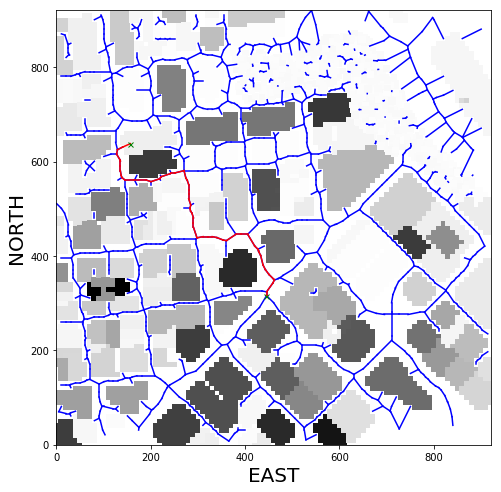

In [34]:
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in G.edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot([start_ne[1], start_ne_g[1]], [start_ne[0], start_ne_g[0]], 'r-')
for i in range(len(path)-1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
plt.plot([goal_ne[1], goal_ne_g[1]], [goal_ne[0], goal_ne_g[0]], 'r-')
    
plt.plot(start_ne[1], start_ne[0], 'gx', ms=5)
plt.plot(goal_ne[1], goal_ne[0], 'gx', ms=5)

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()

In [39]:
def point(p):
    return np.array([p[0], p[1], 1.])

def collinearity_2D(p1, p2, p3, epsilon=1e-6): 
    det = p1[0]*(p2[1] - p3[1]) + p2[0]*(p3[1] - p1[1]) + p3[0]*(p1[1] - p2[1])
    # print(det)
    return abs(det) < epsilon

def prune_path(path):
    # pruned_path = [p for p in path]
    pruned_path = path.copy()
    
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        # If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_2D(p1, p2, p3, 500):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

# prune path to minimize number of waypoints
print(len(path), "waypoints before pruning")
path = prune_path(path)
print(len(path), "waypoints after pruning")

57 waypoints before pruning
9 waypoints after pruning


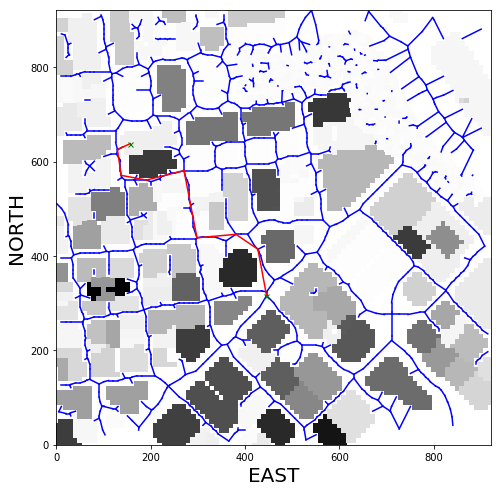

In [41]:
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in G.edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot([start_ne[1], start_ne_g[1]], [start_ne[0], start_ne_g[0]], 'r-')
for i in range(len(path)-1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
plt.plot([goal_ne[1], goal_ne_g[1]], [goal_ne[0], goal_ne_g[0]], 'r-')
    
plt.plot(start_ne[1], start_ne[0], 'gx', ms=5)
plt.plot(goal_ne[1], goal_ne[0], 'gx', ms=5)

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()